# Аггрегирование и гуппировка

Важным элементом анализа больших данных является эффективность суммирования: расчет аггрегаторов типа `sum()`, `mean()`, `median()`, `min()` и `max()`, в которых одно значение может дать информацию о природе потенциально большого набора данных. В данном разделе мы изучим аггрегирование в Pandas, начиная с простых операций, родственных тем, что мы видели в NumPy, и заканчивая более сложными операциями, базирующимися на концепте `groupby`. Для удобства мы будем использовать магическую функцию `display`, с которой работил ранее.

In [38]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Данные по планетам

Здесь мы будем использовать данные по планетам, доступные из пакета [Seaborn](https://seaborn.pydata.org/). Он содержит информацию о планетах, которые астрономы обнаружили вокруг других звёзд (экзопланеты). Набор может быть загружен простой командой:

In [39]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [40]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


## Простая аггрегация в Pandas

Ранее мы [рассмотрели](https://jakevdp.github.io/PythonDataScienceHandbook/02.04-computation-on-arrays-aggregates.html) агрегирование данных для массивов NumPy. Точно также как и для одномерных массивов NumPy, объекты Pandas типа `Series` при агрегировании возвращают единственное значение:

rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

In [41]:
ser.sum()

2.811925491708157

In [42]:
ser.mean()

0.5623850983416314

Для объектов `DataFrame` агрегаты по умолчанию возвращают результаты для каждой колонки:

In [43]:
df = pd.DataFrame({'A': rng.rand(5), 'B': rng.rand(5)})
df

,A,B
0,0.183405,0.611853
1,0.304242,0.139494
2,0.524756,0.292145
3,0.431945,0.366362
4,0.291229,0.456070


In [44]:
df.mean()

A    0.347115
B    0.373185
dtype: float64

С помощью аргумента `axis` вы можете агрегировать по каждому ряду:

In [45]:
df.mean(axis=1)
# аналогичный результат даёт такая конструкция:
# df.mean(axis='columns')

0    0.397629
1    0.221868
2    0.408451
3    0.399153
4    0.373650
dtype: float64

Объекты `Series` и `DataFrame` включают все распространённые агрегаты, упомянутые [тут](https://jakevdp.github.io/PythonDataScienceHandbook/02.04-computation-on-arrays-aggregates.html); в дополнение существует удобный метод `describe()`, который вычисляет несколько наиболее частых агрегатов для каждой колонки и возвращает результат. Давайте используем его на данных о планетах, для примера исключим ряды с пустыми значениями:

In [46]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


Встроенные в Pandas агрегаторы (и для `DataFrame` и для `Series`):

| Aggregation              | Returns                         |
|--------------------------|---------------------------------|
| ``count``                | Total number of items           |
| ``first``, ``last``      | First and last item             |
| ``mean``, ``median``     | Mean and median                 |
| ``min``, ``max``         | Minimum and maximum             |
| ``std``, ``var``         | Standard deviation and variance |
| ``mad``                  | Mean absolute deviation         |
| ``prod``                 | Product of all items            |
| ``sum``                  | Sum of all items                |


## Сгруппировать по: разделить, применить, объединить (combine)

### Разделить, применить, объединить (combine)

Канонический пример операции разделить-применить-объединить, где "применить" означает суммирование агрегированных данных, может быть проиллюстрирован следующей картинкой:
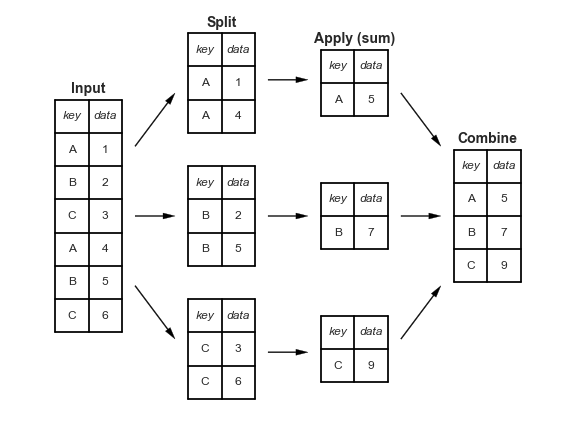

Эта иллюстрация хорошо показывает что `groupby` позволяет достичь.

В качестве конкретного примера, давайте взглянем на использование Pandas для вычислений, показанных на диаграмме. Начнём с создания входного `DataFrame`:

In [47]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'], 'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


Самая базовая операция типа "разделить-применить-объединить" может быть вычислена методом `groupby()` класса `DataFrame` путём передачи ключа необходимой колонки:

In [48]:
df.groupby('key')

Обратите внимание, что операция возвращает не `DataFrame`, а объект `DataFrameGroupBy`. Этот объект в котором происходит вся "магия", в котором не происходит действительных вычислений, пока не применён какой-либо агрегат ("lazy evaluation"). Для получения результата мы можем применить агрегат к объекту типа `DataFrameGroupBy`, который проведёт необходимые "применить-объединить" шаги для производства желаемого результата:

In [49]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


Метод `sum()` в данном случае - это просто пример, может быть применена фактически любая операция `DataFrame`.

### Объект GroupBy

Объект `GroupBy` очень гибкая абстракция. Во многих случаях вы можете использовать его как коллекцию объектов `DataFrame`. Давайте посмотрим несколько примеров используя данные Planets.

Возможно наиболее важными операциями доступными в `GroupBy` являются агрегирование, фильтрация, трансформирование и применение. Мы обсудим все эти операции далее, но сначала давайте введём некоторые другие базовые операции с `GroupBy`.

#### Индексирование колонок

Объект `GroupBy` поддерживает индексирование колонок аналогично `DataFrame` и возвращает модифицированный объект `GroupBy`. Например:

In [50]:
planets.groupby("method")

In [51]:
planets.groupby("method")["orbital_period"]

Здесь мы извлекли из оригинального `DataFrame` конкретную группу в виде объекта `Series` с помощью указание на имя колонки (`orbital_period`).

In [52]:
planets.groupby("method")["orbital_period"].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

#### Итерация по группам

Объект `GroupBy` поддерживает прямую итерацию по группам, возвращая каждую группу как объект `Series` или `DataFrame`:

In [53]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


#### Методы отправки (dispatch)

Любой метод, не имеющий явной реализации в классе `GroupBy` будет передан по цепочке вызовов в каждую группу, внезависимости от типа `DataFrame` или `Series`. Например, вы можете использовать метод `DataFrame.describe()` для выполнения набора агрегаций для описания данных в каждой группе:

In [54]:
planets.groupby("method")["year"].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


### Агрегация, фильтрация, трансформация, применение

Для дальнейших секций мы используем следующий `DataFrame`:

In [56]:
rng = np.random.RandomState(0)
df = pd.DataFrame(
    {
        'key': ['A', 'B', 'C', 'A', 'B', 'C'],
        'data1': range(6),
        'data2': rng.randint(0, 10, 6)
    },
    columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Агрегирование

Мы уже знакомы с методами `sum()` и `median()` объекта `GroupBy`, но метод `aggregate()` представляет намного больше гибкости. Он может принимать несколько параметров и вычислить все агрегаты за раз:

In [62]:
df.groupby("key").aggregate(["min", "median", "max"])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Другой полезный шаблон - это использование словаря сопоставлений имён колонок на операции, которые должны быть применены к конкретной колонке:

In [64]:
df.groupby("key").aggregate({"data1": "min", "data2": "max"})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Фильтрация

Операция фильтрации позволяет вам отбросить данные на основе свойств группы. Например, мы хотим сохранить все группы в которых стандартное отклонение больше некоторого порогового значения:

In [67]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

Функция фильтра должна возвращать булево значение, указывающее будет ли группа пропущена или нет. В примере группа `A` имеет стандартное отклонение меньше 4 и поэтому она была отброшена.

#### Трансформация

https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html#Transformation